# Introduction To Data Science - Final Project

## Group members:

| Name              | ID       |
|-------------------|----------|
| Pham Dang Son Ha |21127206|
| Tran Dai Nien     | 21127664 |
| Nguyen Cao Khoi   | 21127632 |
| Nguyen Phan Minh Triet  | 21126007  |

## Table of Contents

1. [Data Collection](#data-collection)

2. [Data Preprocessing and Exploration](#data-preprocessing-and-exploration)

3. [Data Modeling](#data-modeling)

4. [Reference](#references)

## Data Collection

### 1. Set-up environment

#### Import Required Libraries: Import the necessary Python libraries - requests, BeautifulSoup, pandas, and time.

In [57]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

#Necessary Packages
!pip install bs4
!pip install requests
!pip install pandas
!pip install numpy
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os
import seaborn as sns

from sklearn.model_selection import train_test_split # Split dataset into train set and test set
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV # Hyperparamater tuning
from sklearn.model_selection import cross_val_score # Evaluate model

# Regression Models
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

# TF-IDF:  find relative frequency of a word in a document(used for suggesting relate films)
from sklearn.feature_extraction.text import TfidfVectorizer

# calculate the similarity between two vectors in the feature space
from sklearn.metrics.pairwise import linear_kernel

### 2. Collect data from a website by parsing HTML

#### List of collected information

Information related to the movie, including:

- `names`: Movie titles.
- `years`: Release years of the movies.
- `genres`: Categories or genres the movies belong to.
- `lengths`: Duration or length of the movies.
- `rating_stars`: Ratings received by the movies.
- `metascores`: Metascores assigned to the movies (if available).
- `votes`: Total votes accumulated by the movies.
- `grosses`: Box office gross earnings of the movies (if available).
- `directors`: Directors of the movies.
- `stars`: Lead actors/actresses in the movies.
- `descriptions`: Synopsis or descriptions of the movies.

#### Data Collection Process:

- Identify the URL of the webpage containing the list of movies to be scraped.
- Use the requests library to send GET requests to each page of the IMDb website.
- Parse the HTML of the webpage using BeautifulSoup to extract information about the movies.
- Iterate through each movie to collect details such as title, release year, genre, rating, - Metascore, votes, earnings, director, main cast, and description.
- Store the collected information in a DataFrame using the pandas library.

In [58]:
def collect_data(base_url, num_movies, movies_per_page=100):
    # Initialize lists for storing data
    names = []
    years = []
    genres = []
    lengths = []
    rating_stars = []
    metascores = []
    votes = []
    grosses = []
    directors = []
    stars = []
    descriptions = []

    # Iterate over the specified number of pages
    for page in range(1, int(num_movies / movies_per_page) + 1):
        try:
            # Construct the URL for the current page
            url = f"{base_url}&page={page}"
            
            # Send a GET request to the URL
            response = requests.get(url)
            time.sleep(2)  # Respectful crawling by adding delay

            # Check if the response status code is 200 (OK)
            if response.status_code == 200:
                # Parse the HTML content of the page
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find all movie containers on the page
                movies = soup.find_all('div', class_='lister-item-content')

                # Process each movie
                for movie in movies:
                    # Extract movie details
                    name = movie.find('h3').find('a').text.strip()
                    year = movie.find('span', class_='lister-item-year').text.strip('()')
                    genre = movie.find('span', class_='genre').text.strip()
                    length = movie.find('span', class_='runtime').text.strip().split()[0]
                    rating = movie.find('span', class_='ipl-rating-star__rating').text.strip()

                    # Some movies might not have a metascore
                    metascore_tag = movie.find('span', class_='metascore')
                    metascore = metascore_tag.text.strip() if metascore_tag else 'N/A'

                    # Extract votes and gross, if available
                    nv_tags = movie.find_all('span', attrs={'name': 'nv'})
                    vote = nv_tags[0].text if nv_tags else 'N/A'
                    gross = nv_tags[1].text if len(nv_tags) > 1 else 'N/A'

                    # Extract director and stars
                    director, *star_list = movie.find_all('a', href=lambda href: href and 'name/nm' in href)
                    director = director.text
                    stars_str = ', '.join(star.text for star in star_list)

                    # Extract description
                    description = movie.find_all('p', class_='')[-1].text.strip()

                    # Append the extracted data to respective lists
                    names.append(name)
                    years.append(year)
                    genres.append(genre)
                    lengths.append(length)
                    rating_stars.append(rating)
                    metascores.append(metascore)
                    votes.append(vote)
                    grosses.append(gross)
                    directors.append(director)
                    stars.append(stars_str)
                    descriptions.append(description)

            else:
                print(f"Failed to process page {page}: Status code {response.status_code}")

        except requests.exceptions.RequestException as e:
            print(f"Request error on page {page}: {e}")
        except Exception as e:
            print(f"Error on page {page}: {e}")

    # Create a DataFrame with the collected data
    data = pd.DataFrame({
        'Name': names,
        'Year': years,
        'Genre': genres,
        'Length': lengths,
        'Rating': rating_stars,
        'Metascore': metascores,
        'Votes': votes,
        'Gross': grosses,
        'Director': directors,
        'Stars': stars,
        'Description': descriptions
    })

    return data

#### Collecting Movie Data from IMDb

- Identify the URL of the webpage containing the list of movies to be scraped.

- Use the collect_data function to gather information from the webpage based on the desired number of pages and movies.


In [59]:
# Specify the URL containing the list of movies
url = "https://www.imdb.com/list/ls051785783/?st_dt=&mode=detail&sort=list_order,asc"

# Scrape the data

if os.path.isfile('data_film.csv'):
  data_film = pd.read_csv('data_film.csv')
else: 
  data_film = collect_data(url, 1500, 100)

#### Data Storage

- Store the collected data in a CSV file named data_film.csv using data_film.to_csv().
- Read the data from the CSV file into a new DataFrame (data_film) using pd.read_csv().

In [60]:
#Save to csv file with name data_film.csv
# Save the DataFrame to a CSV file without including the index
data_film.to_csv("data_film.csv", index=False)

# Read the CSV file into a new DataFrame called data_film
data_film = pd.read_csv("data_film.csv")

# Display the 'data_film' DataFrame
data_film

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
0,Bố Già,1972,"Crime, Drama",175,9.2,100.0,"1,967,180",$134.97M,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...","Don Vito Corleone, head of a mafia family, dec..."
1,Chuyện Tình Thế Chiến,1942,"Drama, Romance, War",102,8.5,100.0,"595,530",$1.02M,Michael Curtiz,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",A cynical expatriate American cafe owner strug...
2,Sinh Viên Tốt Nghiệp,1967,"Comedy, Drama, Romance",106,8.0,83.0,"284,817",$104.95M,Mike Nichols,"Dustin Hoffman, Anne Bancroft, Katharine Ross,...",A disillusioned college graduate finds himself...
3,Công Dân Kane,1941,"Drama, Mystery",119,8.3,100.0,"458,887",$1.59M,Orson Welles,"Orson Welles, Joseph Cotten, Dorothy Comingore...",Following the death of publishing tycoon Charl...
4,12 Người Đàn Ông Giận Dữ,1957,"Crime, Drama",96,9.0,97.0,"841,356",$4.36M,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",The jury in a New York City murder trial is fr...
...,...,...,...,...,...,...,...,...,...,...,...
1495,Quái Thú Vô Hình,1987,"Action, Adventure, Horror",107,7.8,47.0,"444,578",$59.74M,John McTiernan,"Arnold Schwarzenegger, Carl Weathers, Kevin Pe...",A team of commandos on a mission in a Central ...
1496,Chuyến Du Lịch Châu Âu,2004,Comedy,92,6.6,45.0,"218,869",$17.72M,Jeff Schaffer,"Alec Berg, David Mandel, Scott Mechlowicz, Jac...","Dumped by his girlfriend, a high school grad d..."
1497,Champagne,1928,Comedy,86,5.4,NaN,"2,572",NaN,Alfred Hitchcock,"Betty Balfour, Jean Bradin, Ferdinand von Alte...",A spoiled heiress defies her father by running...
1498,Thế Giới Không Đủ,1999,"Action, Adventure, Thriller",128,6.4,57.0,"207,600",$126.94M,Michael Apted,"Pierce Brosnan, Sophie Marceau, Robert Carlyle...",James Bond uncovers a nuclear plot while prote...


## Data Preprocessing And Exploration

### 1) How many rows and columns

- There are 1500 rows and 11 columns

In [61]:
data_film.shape

(1500, 11)

### 2) What is the meaning of each row?

- Each row represents the information of a film(name, year, genres,...)

In [62]:
data_film.sample(5)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
1383,Choke,2008,"Comedy, Drama",92,6.4,47.0,"33,344",$2.93M,Clark Gregg,"Sam Rockwell, Anjelica Huston, Kelly Macdonald...",A sex-addicted con-man pays for his mother's h...
1392,Cat Ballou,1965,Western,97,6.7,60.0,"15,813",$20.67M,Elliot Silverstein,"Jane Fonda, Lee Marvin, Michael Callan, Dwayne...",A young schoolteacher turns into an outlaw to ...
1103,Giang Hồ Mê Điện Ảnh,1995,"Comedy, Crime, Thriller",105,6.9,82.0,"87,609",$72.08M,Barry Sonnenfeld,"Gene Hackman, Rene Russo, Danny DeVito, John T...",A mobster travels to Hollywood to collect a de...
155,Chuộc Lỗi,2007,"Drama, Mystery, Romance",123,7.8,85.0,"293,920",$50.93M,Joe Wright,"Keira Knightley, James McAvoy, Brenda Blethyn,...",Thirteen-year-old fledgling writer Briony Tall...
360,Đương Đầu Với Thử Thách,1988,"Action, Thriller",132,8.2,72.0,"918,518",$83.01M,John McTiernan,"Bruce Willis, Alan Rickman, Bonnie Bedelia, Re...",A New York City police officer tries to save h...


### 3) Are there duplicated rows?

There is 0 duplicated row

In [63]:
data_film.duplicated().sum()

0

### 4) What is the meaning of each columns

- `names`: Movie titles.
- `years`: Release years of the movies.
- `genres`: Categories or genres the movies belong to.
- `lengths`: Duration or length of the movies.
- `rating_stars`: Ratings received by the movies.
- `metascores`: Metascores assigned to the movies (if available).
- `votes`: Total votes accumulated by the movies.
- `grosses`: Box office gross earnings of the movies (if available).
- `directors`: Directors of the movies.
- `stars`: Lead actors/actresses in the movies.
- `descriptions`: Synopsis or descriptions of the movies.

### 5) What is the current data type of each column? Are there any columns having inappropriate data types?

In [64]:
data_film.dtypes

Name            object
Year            object
Genre           object
Length           int64
Rating         float64
Metascore      float64
Votes           object
Gross           object
Director        object
Stars           object
Description     object
dtype: object

In [65]:
data_film.sample(1)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
803,The Naked Spur,1953,"Drama, Thriller, Western",91,7.3,NaN,"12,430",NaN,Anthony Mann,"James Stewart, Janet Leigh, Robert Ryan, Ralph...",A bounty hunter trying to bring a murderer to ...


- There are some columns which have inappropriate type: `Year, Votes, Gross`

- For `Year, Votes` we can simply convert them into **numeric**. But with `Gross` we need to change columns name to `Gross(M$)` to indicated that `Gross` unit is million Dollars

In [66]:
# remove ',' in Votes
data_film.Votes = data_film.Votes.str.replace(',', '')

# remove $, M in Gross and create new column `Gross(M$)`
data_film['Gross(M$)'] = data_film.Gross.str.replace('M', '').str.replace('$', '')

# drop Gross
data_film.drop(columns='Gross', inplace=True)

In [67]:
data_film.sample(1)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Director,Stars,Description,Gross(M$)
270,M - Eine Stadt sucht einen Mörder,1931,"Crime, Mystery, Thriller",117,8.3,NaN,165456,Fritz Lang,"Peter Lorre, Ellen Widmann, Inge Landgut, Otto...",When the police in a German city are unable to...,0.03


- Convert them into **numeric**

In [68]:
to_numeric_cols = ['Year', 'Votes', 'Gross(M$)']

for col in to_numeric_cols:
  data_film[col] = pd.to_numeric(data_film[col], errors='coerce')

data_film.dtypes

Name            object
Year           float64
Genre           object
Length           int64
Rating         float64
Metascore      float64
Votes            int64
Director        object
Stars           object
Description     object
Gross(M$)      float64
dtype: object

### 6) With each numerical column, how are values distributed?

- All numerical columns:

In [69]:
numerical_cols = data_film.columns[(data_film.dtypes != 'object')]
numerical_cols

Index(['Year', 'Length', 'Rating', 'Metascore', 'Votes', 'Gross(M$)'], dtype='object')

#### 6.1) What is the percentage of missing values?

- Number of missing values of each columns

In [70]:
data_film[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1472 non-null   float64
 1   Length     1500 non-null   int64  
 2   Rating     1500 non-null   float64
 3   Metascore  1211 non-null   float64
 4   Votes      1500 non-null   int64  
 5   Gross(M$)  1121 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 70.4 KB


- The percentage of missing values for each columns

<BarContainer object of 11 artists>

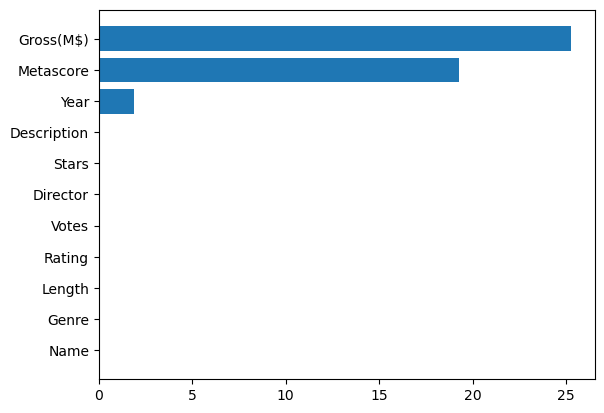

In [71]:
sorted_data_film_missing_percentage = (data_film.isnull().mean() * 100).sort_values()
plt.barh(sorted_data_film_missing_percentage.index, sorted_data_film_missing_percentage.values)


> `Gross(M$)` and `Metascore` missing value's percentage are high

- the `Year` missing values is not significant, so we can drop observations which has missing `Year` value

In [72]:
data_film.dropna(subset=['Year'], inplace=True)

- For `Gross(M$)` and `Metascore`, we will impute median for missing value 

In [73]:
cols = ['Gross(M$)', 'Metascore']

for col in cols:
    data_film[col].fillna(data_film[col].median(), inplace=True)

- Check if any missing values left

In [74]:
data_film.isna().sum()

Name           0
Year           0
Genre          0
Length         0
Rating         0
Metascore      0
Votes          0
Director       0
Stars          0
Description    0
Gross(M$)      0
dtype: int64

- The distribution of numerical attributes

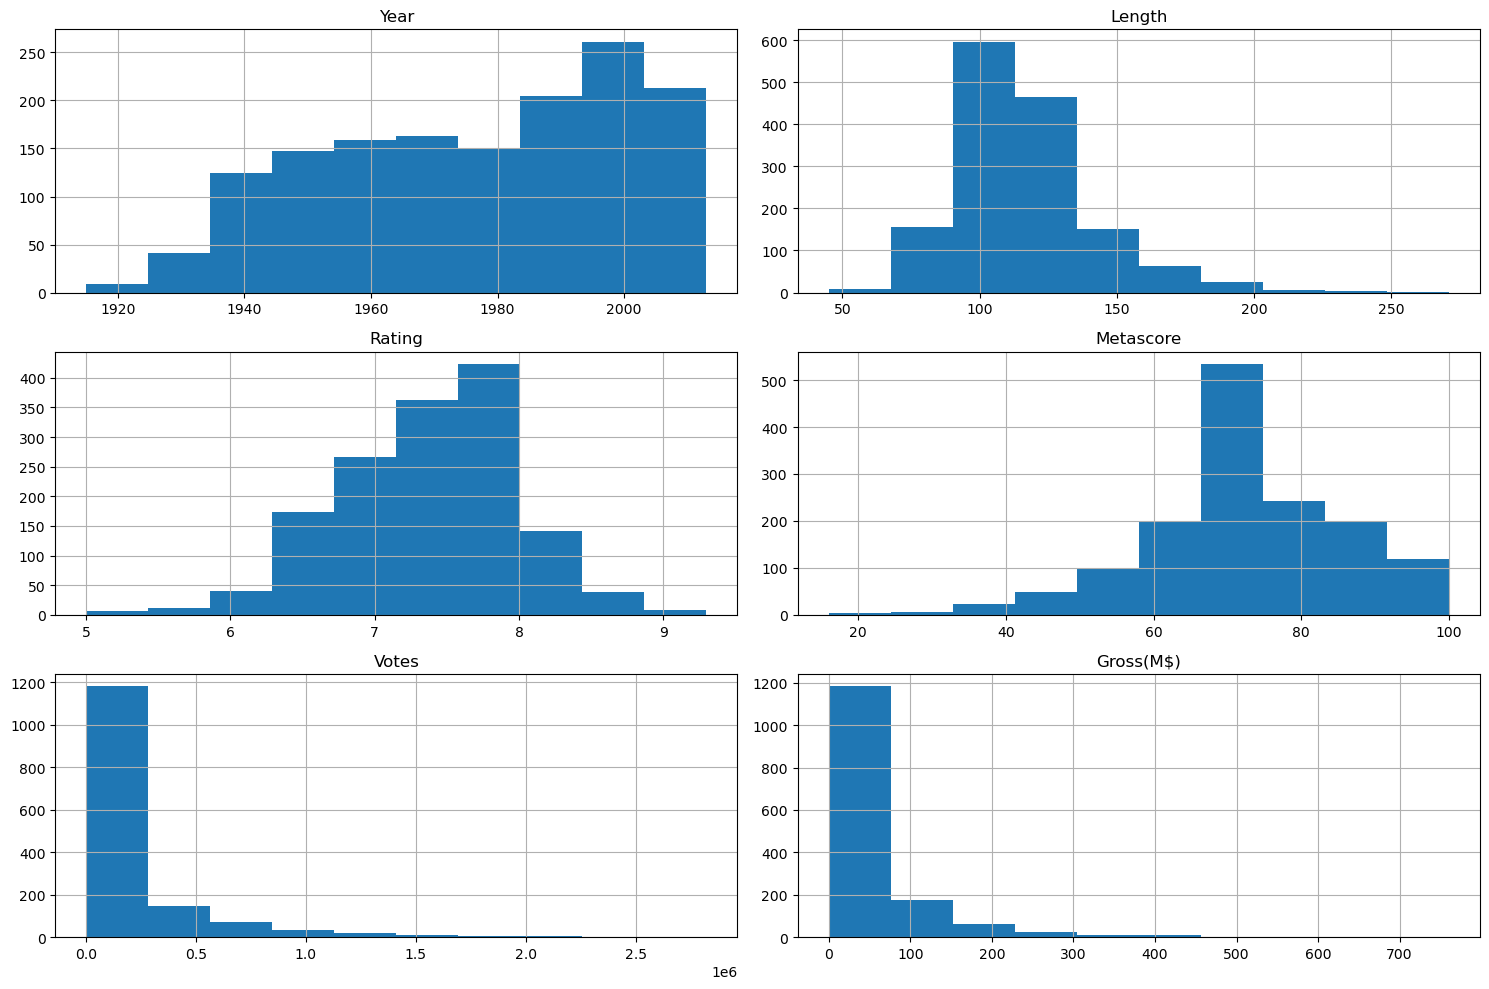

In [75]:
data_film[numerical_cols].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

- General statistics of numerical attributes

In [76]:
data_film[numerical_cols].describe()

,Year,Length,Rating,Metascore,Votes,Gross(M$)
count,1472.000000,1472.000000,1472.00000,1472.000000,1.472000e+03,1472.000000
mean,1976.701087,115.565217,7.37500,72.851902,1.987333e+05,54.047317
std,23.640039,25.600733,0.61515,13.204394,3.276808e+05,71.184540
min,1915.000000,45.000000,5.00000,16.000000,4.400000e+02,0.010000
25%,1957.000000,99.000000,7.00000,66.000000,1.919675e+04,16.182500
50%,1980.000000,112.000000,7.40000,73.000000,7.264400e+04,32.725000
75%,1998.000000,127.000000,7.80000,82.000000,2.269865e+05,56.852500
max,2013.000000,271.000000,9.30000,100.000000,2.822322e+06,760.510000


### 7) With each categorical column, how are values distributed?

- Quick glance at categorical columns

In [77]:
categorical_cols = data_film.columns[data_film.dtypes == 'object']

categorical_cols

Index(['Name', 'Genre', 'Director', 'Stars', 'Description'], dtype='object')

- Convert object to category

In [78]:
new_data_film = data_film.copy()
for label, content in data_film.items():
    if pd.api.types.is_string_dtype(content):
        new_data_film[label] = pd.Categorical(content).codes + 1 # -1 means there is missing value. so we +1 

In [79]:
new_data_film.head(1)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Director,Stars,Description,Gross(M$)
0,166,1972.0,148,175,9.2,100.0,1967180,160,936,826,134.97


In [80]:
data_film.head(1)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Director,Stars,Description,Gross(M$)
0,Bố Già,1972.0,"Crime, Drama",175,9.2,100.0,1967180,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...","Don Vito Corleone, head of a mafia family, dec...",134.97


- Missing values = 0

In [81]:
for col in categorical_cols:
    print(new_data_film[col].isna().sum())

0
0
0
0
0


- The distribution of `Name`: the counts is not significantly different so we won't plot this

In [82]:
data_film.Name.value_counts()

The Man Who Knew Too Much    2
Hamlet                       2
Cặp Bài Trùng                2
All the King's Men           2
Kẻ Cắp Gặp Bà Già            2
                            ..
Anatomy of a Murder          1
Tin Tức Phát Sóng            1
Đội Nhặt Banh                1
Peter Pan                    1
You Gotta Stay Happy         1
Name: Name, Length: 1462, dtype: int64

- The distribution of `Genre`

In [83]:
data_film.Genre.value_counts()

Drama                        92
Comedy, Drama, Romance       70
Drama, Romance               68
Comedy                       67
Comedy, Drama                61
                             ..
Comedy, Fantasy, Musical      1
Drama, Horror, Mystery        1
Mystery, Sci-Fi, Thriller     1
Action, Crime, Romance        1
Action, Adventure, Horror     1
Name: Genre, Length: 233, dtype: int64

- The distribution of top 20 `Genres`

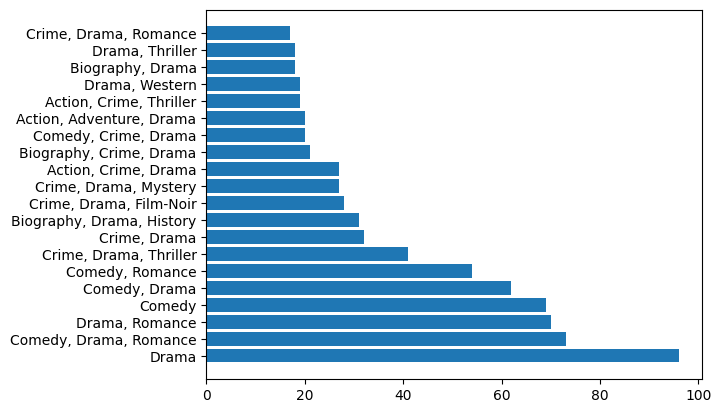

In [84]:
genre_counts = data_film.Genre.value_counts()[:20]
plt.barh(genre_counts.index, genre_counts.values)
plt.show()

- The distribution of `Director`

In [85]:
data_film.Director.value_counts()

Alfred Hitchcock    33
Woody Allen         24
Steven Spielberg    17
Clint Eastwood      15
Billy Wilder        14
                    ..
Richard Kelly        1
Bob Rafelson         1
Mike Mills           1
Luchino Visconti     1
Michael Apted        1
Name: Director, Length: 643, dtype: int64

- The distribution of top 20 `Director`

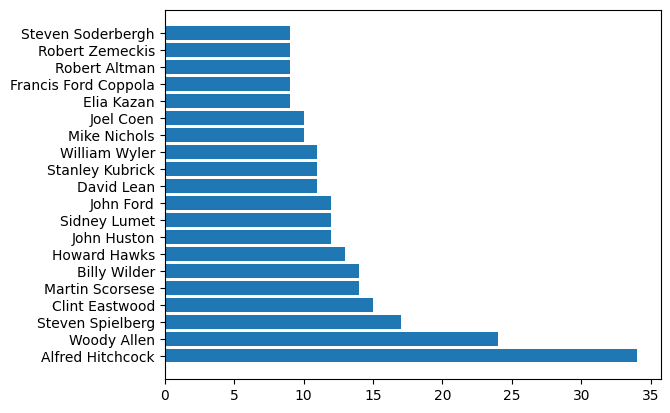

In [86]:
director_counts = data_film.Director.value_counts()[:20]
plt.barh(director_counts.index, director_counts.values);
plt.show()

- The distribution of `Stars`: 

- Top 10 lead stars and their participated movies' count

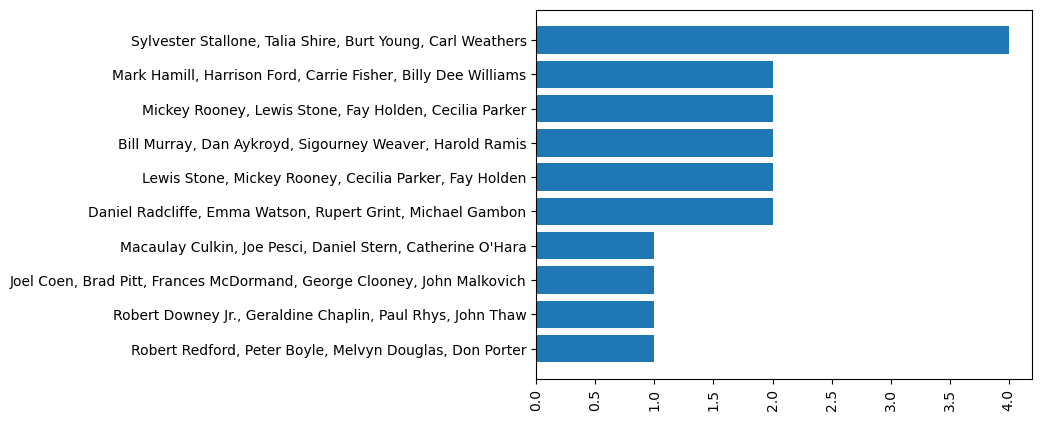

In [87]:
star_counts = data_film.Stars.value_counts()[:10].sort_values()
plt.barh(star_counts.index, star_counts.values);
plt.xticks(rotation=90)
plt.show();

- The distribution of `Description`: each description is different so we won't plot this

In [88]:
data_film.Description.value_counts()

Don Vito Corleone, head of a mafia family, decides to hand over his empire to his youngest son Michael. However, his decision unintentionally puts the lives of his loved ones in grave danger.                             1
An abortion clinic worker with a special heritage is called upon to save the existence of humanity from being negated by two renegade angels trying to exploit a loop-hole and reenter Heaven.                              1
After his auto-parts tycoon father dies, the overweight, underachieving son teams up with a snide accountant to try and save the family business.                                                                           1
A boy and a girl from different backgrounds fall in love regardless of their upbringing - and then tragedy strikes.                                                                                                         1
Ronald's high-school valedictory address praises books and condemns sports. His girlfriend Mary condemns his att

#### 7.1) What is the percentage of missing values?

- As we can see all the categorical columns has 0 missing value so the perccentage will be: 0%

### 8) Are they abnormal?

- After considering the distribution of each attributes, we can conclude that the values are good enough for us to use for model training and get insights from them. 

### 9) Making questions for exploration?

#### 9.1) Question 1: Which genres should we as a director want to make with?

- Purposes: By analyzing historical data on movie ratings and box office performance across different genres, we can identify which genres tend to be more well-received by audiences and/or more profitable. This can help the director choose a genre that aligns with their goals, whether it’s to create a critically acclaimed film, a box office hit, or both.

- Approaches: 

    + `Analyzing on Rating`: We can group the data by genres and calculate the average Rating (or Metascore) for each genre. This can give us an idea of which genres are generally more well-received.

    + `Analyzing on Gross`: We can group the data by genres and calculate the average Gross for each genre. This can give us an idea of which genres are generally more profitable.

##### Exploring about the genre of the movies

In [89]:
# We'll split the genres column into separate rows
df_genres = data_film.assign(Genre_Split=data_film['Genre'].str.split(',')).explode('Genre_Split')

# Remove leading and trailing spaces
df_genres['Genre_Split'] = df_genres['Genre_Split'].str.strip()

# Get unique genres
unique_genres = df_genres['Genre_Split'].unique()

# Print the number of unique genres
print("Number of unique genres:", len(unique_genres))

# Print all unique genres
print("Unique genres:", unique_genres)


Number of unique genres: 21
Unique genres: ['Crime' 'Drama' 'Romance' 'War' 'Comedy' 'Mystery' 'Action' 'Western'
 'Thriller' 'Adventure' 'Family' 'Fantasy' 'Film-Noir' 'Biography'
 'History' 'Sci-Fi' 'Sport' 'Horror' 'Music' 'Musical' 'Animation']


- Explanation:

    + `Crime`: These films revolve around the sinister actions of criminals, mobsters, bank robbers, underworld figures, and ruthless hoodlums who operate outside the law, stealing and murdering their way through life.
    
    + `Drama`: Drama films are serious presentations or stories with settings or life situations that portray realistic characters in conflict with either themselves, others, or forces of nature.

    + `Romance`: Romance films are love stories that focus on passion, emotion, and the affectionate romantic involvement of the main characters, and the journey that their love takes them through dating, courtship or marriage.
    
    + `War`: War films acknowledge the horror and heartbreak of war, letting the actual combat fighting or conflict (against nations or humankind) provide the primary plot or background for the action of the film.

    + `Comedy`: Comedies are light-hearted plots consistently and deliberately designed to amuse and provoke laughter (with one-liners, jokes, etc.) by exaggerating the situation, the language, action, relationships and characters.

    + `Mystery`: These are types of films that make us think and keep us guessing. They deal with our sense of unease and anxiety.

    + `Action`: Action films usually include high energy, big-budget physical stunts and chases, possibly with rescues, battles, fights, escapes, destructive crises (floods, explosions, natural disasters, fires, etc.), non-stop motion, spectacular rhythm and pacing, and adventurous, often two-dimensional ‘good-guy’ heroes (or recently, heroines) battling ‘bad guys’ - all designed for pure audience escapism.
    
    + `Western`: Westerns are the major defining genre of the American film industry, a nostalgic eulogy to the early days of the expansive, untamed American frontier (the borderline between civilization and the wilderness).
    
    + `Thriller`: Thrillers are tension-laden, complex, mysterious, and often involve crime (solution of a murder, disappearance, theft, etc.).
    
    + `Adventure`: Adventure films are exciting stories, with new experiences or exotic locales, very 
    similar to or often paired with the action film genre.

    + `Family`: These are films that are designed to be suitable for all ages.

    + `Fantasy`: Fantasy films are films with fantastic themes, usually involving magic, supernatural 
    events, mythology, folklore, or exotic fantasy worlds.
    
    + `Film-Noir`: Film noir is a cinematic term used primarily to describe stylish Hollywood crime dramas, particularly those that emphasize cynical attitudes and sexual motivations.
    
    + `Biography`: These films depict and dramatize the life of an important historical personage (or group) from the past or present era.
    
    + `History`: Films in this genre focus on recreating a specific and important period or event in history.
    
    + `Sci-Fi`: Science fiction films are often quasi-scientific, visionary and imaginative - complete with heroes, aliens, distant planets, impossible quests, improbable settings, fantastic places, great dark and shadowy villains, futuristic technology, unknown and unknowable forces, and extraordinary monsters (‘things or creatures from space’), either created by mad scientists or by nuclear havoc.
    
    + `Sport`: Sports films are those that have a sports setting (football or baseball stadium, arena, or the Olympics, etc.), competitive event (the ‘big game,’ ‘fight,’ or ‘race’), athletes (boxers, racers, etc.), or coach in the storyline.
    
    + `Horror`: Horror films are designed to frighten and to invoke our hidden worst fears, often in a terrifying, shocking finale, while captivating and entertaining us at the same time in a cathartic experience.
    
    + `Music`: These are films that are centered around music and dance.
    
    + `Musical`: Musicals/Dance films are cinematic forms that emphasize and showcase full-scale song and dance routines in a significant way (usually with a musical or dance performance integrated as part of the film narrative, or as an unrealistic “eruption” within the film).

    + `Animation`: Animated films are ones in which individual drawings, paintings, or illustrations are photographed frame by frame.

##### Analyzing on Rating

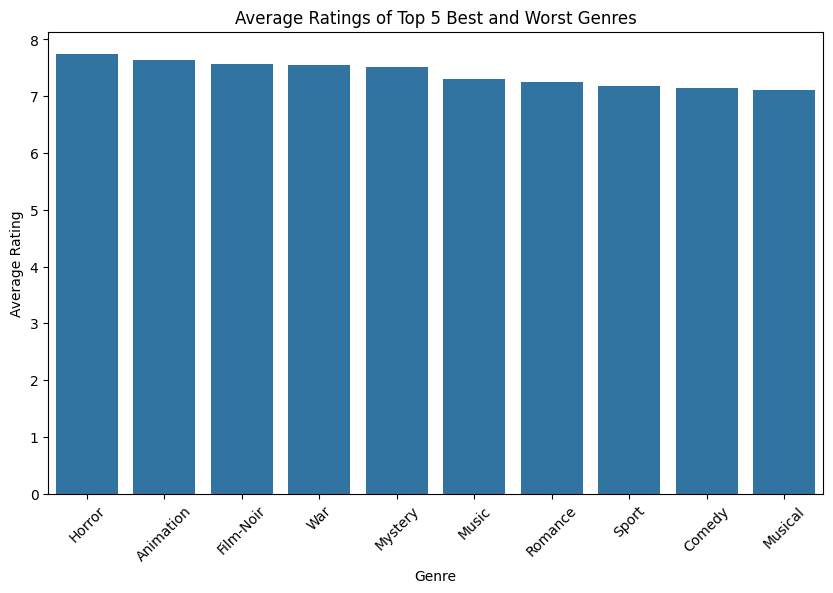

In [90]:
# Then, we group by genres and calculate the average rating_stars
average_ratings = df_genres.groupby('Genre_Split')['Rating'].mean()

# Finally, we sort the result in descending order so the genres with the highest average ratings are on top
average_ratings = average_ratings.sort_values(ascending=False)

# Get the top 5 and bottom 5 genres
top_5 = average_ratings.head(5)
bottom_5 = average_ratings.tail(5)

# Combine them into one Series
combined = pd.concat([top_5, bottom_5])

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=combined.index, y=combined.values)
plt.title('Average Ratings of Top 5 Best and Worst Genres')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

=> Conclusion: Based on the data analysis, the top five genres with the highest average rating scores are Horror, Animation, Film-Noir, War, and Mystery. This suggests that movies in these genres tend to be more well-received by audiences, as indicated by their higher average ratings.

On the other hand, the genres with the lowest average rating scores are Musical, Comedy, Sport, Romance, Music. This suggests that movies in these genres tend to receive lower ratings from audiences.

This analysis provides a general trend and can be a useful guide for filmmakers when choosing a genre for their next project.

##### Analyzing on Gross

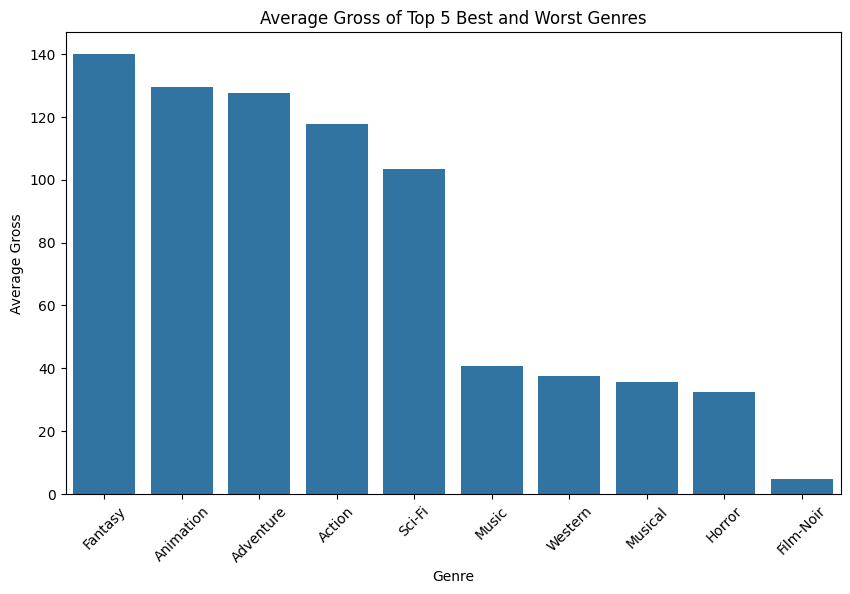

In [91]:
# Group by genres and calculate the average gross
average_gross = df_genres.groupby('Genre_Split')['Gross(M$)'].mean()

# Sort the result in descending order so the genres with the highest average gross are on top
average_gross = average_gross.sort_values(ascending=False)

# Get the top 5 and bottom 5 genres
top_5_gross = average_gross.head(5)
bottom_5_gross = average_gross.tail(5)

# Combine them into one Series
combined_gross = pd.concat([top_5_gross, bottom_5_gross])

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_gross.index, y=combined_gross.values)
plt.title('Average Gross of Top 5 Best and Worst Genres')
plt.xlabel('Genre')
plt.ylabel('Average Gross')
plt.xticks(rotation=45)
plt.show()

=> Conclusion: Based on the data analysis, the top five genres with the highest average gross are Fantasy, Animation, Adventure, Action and Sci-Fi. This suggests that movies in these genres tend to be more profitable, as indicated by their higher gross.

On the other hand, the genres with the lowest gross are Film-Noir, Horror, Musical, Western and Music. This suggests that movies in these genres tend to receive lower gross and not popluar with audiences.

This analysis provides a general trend and can be a useful guide for filmmakers when choosing a genre for their next project.

##### Final conclusion: 

    + Animation is the genre which tend to be more favoured by audiences and bring more profit for the filmakers because of it's high value on both Rating and Gross
    
    + Music and Musical are the 2 types of genre that generally bring low income to the company and are not favourable among audiences

#### 9.2) Question 2: How have the movie lengths and genres evolved over the year?

- Purpose: 

    + To understand the trends and changes in movie lengths and genres over time. This can provide insights into how the film industry has evolved and changed, reflecting shifts in cultural tastes, technological advancements, and other factors.

    + By analyzing this, we can gain a deeper understanding of the film industry’s history and potentially predict future trends. For filmmakers, this information could be useful in making decisions about what type of films to produce. For film enthusiasts or researchers, it could provide interesting insights into the evolution of cinema. 

- Appoaches:

    + `Yearly Average Movie Length`: Group the data by year and calculate the average movie length for each year. Plotting these averages over time can show how movie lengths have changed.

    + `Genre Popularity Over Time`: For each year, calculate the number of movies produced in each genre. Plotting these numbers can show how the popularity of different genres has evolved.

##### Yearly Average Movie Length

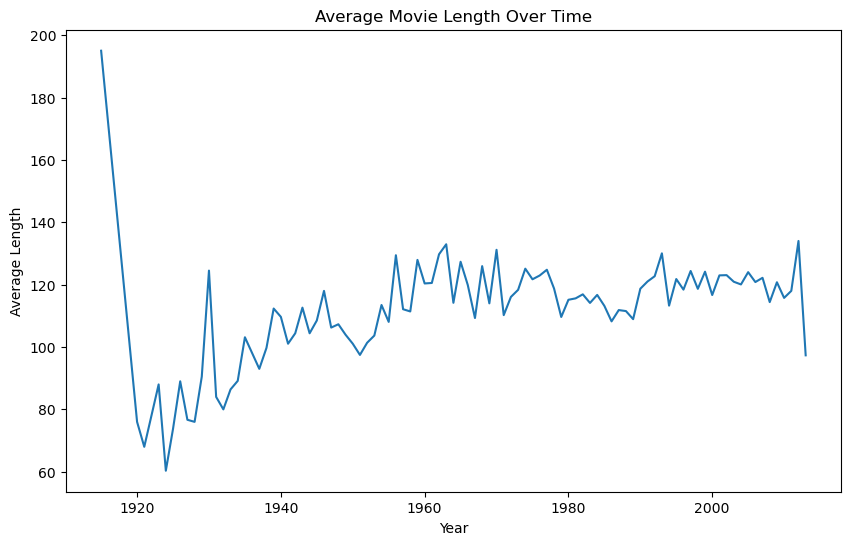

In [92]:
# Group by year and calculate the average length
average_lengths = data_film.groupby('Year')['Length'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
average_lengths.plot(kind='line')
plt.title('Average Movie Length Over Time')
plt.xlabel('Year')
plt.ylabel('Average Length')
plt.show()

=> Conclusion: Over the given period, the length of movies as a whole decrease from roughly 200 minutes to around 90 minutes per movie.
Around 1920, the length of the movies witnessed a sharp decrease from around 200 to 75 minutes. After that time the length of the movies fuctuate between 60 and 120 minutes. In the recent years the length of the movies is falling and likely still fall in the future


##### Genre Popularity Over Time

C:\Users\PhamDangSonHa\AppData\Local\Temp\ipykernel_2776\2575019706.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_counts = copy_df_genres.groupby(['Time_Period', 'Genre_Split']).size()


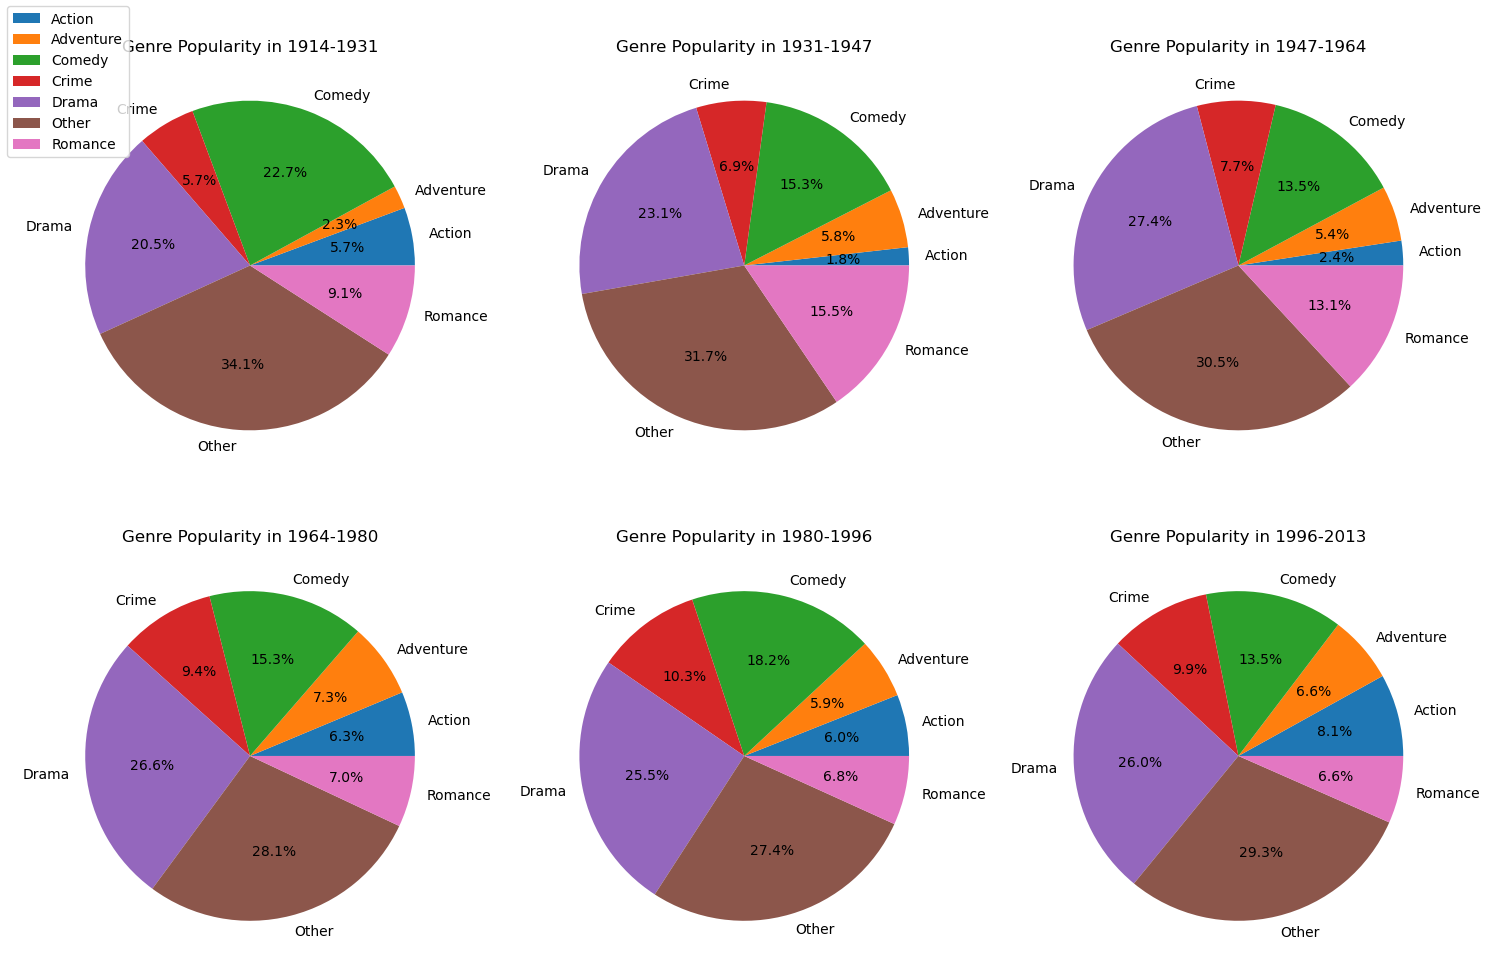

In [93]:
#Make a copy of df_genres
copy_df_genres = df_genres.copy()

# Get the top 5 genres
top_genres = copy_df_genres['Genre_Split'].value_counts().index[:6]

# Replace all other genres with 'Other'
copy_df_genres['Genre_Split'] = copy_df_genres['Genre_Split'].where(copy_df_genres['Genre_Split'].isin(top_genres), 'Other')

# Convert the 'Year' column to numeric, coercing errors to NaN
copy_df_genres['Year'] = pd.to_numeric(copy_df_genres['Year'], errors='coerce')

# Drop rows with NaN in the 'Year' column
copy_df_genres = copy_df_genres.dropna(subset=['Year'])

# Divide the data into six time periods
copy_df_genres['Time_Period'] = pd.cut(copy_df_genres['Year'], bins=6)

# Count the number of movies in each genre for each time period
genre_counts = copy_df_genres.groupby(['Time_Period', 'Genre_Split']).size()

# Reset the index to make 'Time_Period' and 'Genre_Split' regular columns
genre_counts = genre_counts.reset_index(name='Count')

# Get the unique time periods
time_periods = genre_counts['Time_Period'].unique()

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loop over the time periods and plot the data in a separate subplot
for i, period in enumerate(time_periods):
    # Get the data for this time period
    data = genre_counts[genre_counts['Time_Period'] == period]
    
    # Calculate the row and column indices for the subplot
    row = i // 3
    col = i % 3
    
    # Create the pie chart in the subplot
    axs[row, col].pie(data['Count'], labels=data['Genre_Split'], autopct='%1.1f%%')
    axs[row, col].set_title('Genre Popularity in ' + str(int(period.left)) + '-' + str(int(period.right)))

# Add a legend
fig.legend(genre_counts['Genre_Split'].unique(), loc='upper left')

# Adjust the layout
plt.tight_layout()
plt.show()

=> Conclusion: In general, Drama , which over the six period accounts for 20%-25%, is the most popular genre among all.

Over the time, the proportion of Crime, Adventure and Action increase over the years. In contrast, the percentage of Comedy and Romance movies falls over the given period.

##### Final conclusion:

+ The length of a movie decrease over time and this status seem to continue in the future

+ Drama movie is the most popular movie type. Over the time the proportion of Crime, Adventure and Action increases, the percentage of Comedy and Romance decreases.

#### 9.3) Question 3: Does a good movie  comes with certain actors/actress?

- Purposes:

    + To understand if the presence of certain actors or actresses in a movie can be a predictor of the movie’s quality or success. It can help in understanding trends in the film industry and can potentially guide decisions about casting for future films.

    + Help viewers to find the good movies to watch just based on the casts.

- Approaches:

    + Step 1 - Define Success: We need to define what a “good” movie is. It could be based on Rating, Gross, or a combination of factors.

    + Step 2 - Analyze Movie Success: For each actors/actresses, calculate the average Rating and Gross of the movies they’ve starred in. Compare these averages to the overall averages to see if movies featuring these actors/actresses tend to be more successful.

    + Step 3 - Visualize the Results: Create bar plots or other visualizations to compare the success of movies with different actors/actresses. This could help visually identify any trends or patterns.

##### Exploring about the Stars in the movie data

In [94]:
# We'll split the Stars column into separate rows
df_stars = data_film.assign(Stars_Split=data_film['Stars'].str.split(',')).explode('Stars_Split')

# Remove leading and trailing spaces
df_stars['Stars_Split'] = df_stars['Stars_Split'].str.strip()

# Get unique stars
unique_stars = df_stars['Stars_Split'].unique()

# Print the number of unique stars
print("Number of unique stars:", len(unique_stars))

# Print all unique stars
print("Unique stars:", unique_stars)

Number of unique stars: 3018
Unique stars: ['Marlon Brando' 'Al Pacino' 'James Caan' ... 'Robert Carlyle'
 'Denise Richards' 'Roland Young']


##### Exploring the success of each star

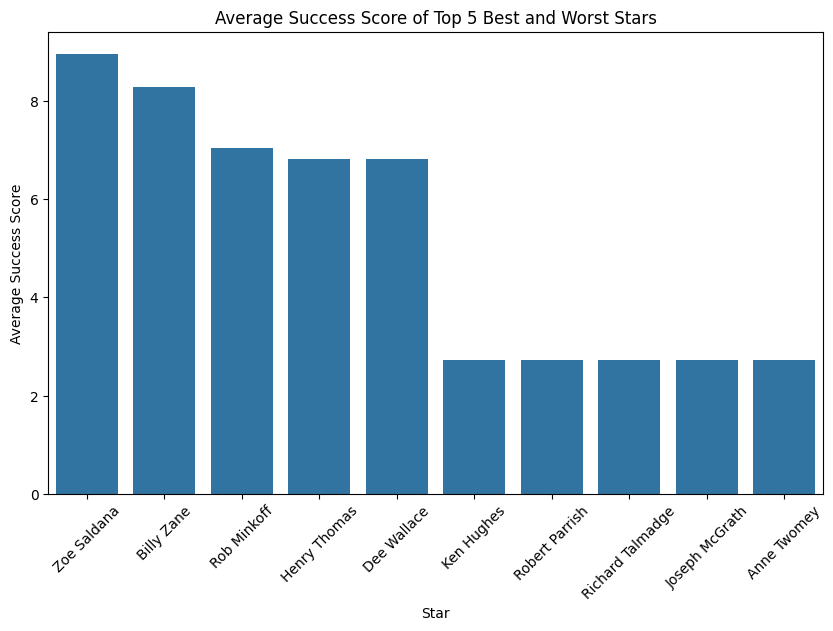

In [95]:
# Calculate the median of 'Gross(M$)'
gross_median = df_stars['Gross(M$)'].median()

# Fill in missing values in 'Gross(M$)' with the median
df_stars['Gross(M$)'].fillna(gross_median, inplace=True)

# Normalize 'grosses' to a 0-10 scale to create 'Gross_Point'
df_stars['Gross_Point'] = (df_stars['Gross(M$)'] - df_stars['Gross(M$)'].min()) / (df_stars['Gross(M$)'].max() - df_stars['Gross(M$)'].min()) * 10

# Create 'Success' column as the average of 'rating_stars' and 'Gross_Point'
df_stars['Success'] = df_stars[['Rating', 'Gross_Point']].mean(axis=1)

# Group the data by 'Stars_Split' and calculate the average 'Success' for each star
average_success= df_stars.groupby('Stars_Split')['Success'].mean()

# Sort the average success scores in descending order
average_success = average_success.sort_values(ascending=False)

# Get the top 5 stars with the highest and lowest average success scores
top_5 = average_success.head(5)
bottom_5 = average_success.tail(5)

# Combine the top 5 and bottom 5 stars into one Series
combined = pd.concat([top_5, bottom_5])

# Create a bar plot of the average success scores of the top 5 and bottom 5 stars
plt.figure(figsize=(10, 6))
sns.barplot(x=combined.index, y=combined.values)
plt.title('Average Success Score of Top 5 Best and Worst Stars')
plt.xlabel('Star')
plt.ylabel('Average Success Score')
plt.xticks(rotation=45)
plt.show()

##### Final conclusion:

+ We can see that the top 5 best actors includes: Zoe Saldana, Billy Zane, Rob Minkoff, Henry Thomas and Dee Wallace. These are the people who tend to make the movies, in which they play a role, successful. Filmmaker should prioritize these casts.

+ On the contrary, Ken Hughes, Robert Parrish, Richard Talmadge, Joseph McGrath and Anne Twomey are the 5 stars who seem not to contribute to the success of the movies because of their low Success Score. Filmmaker should avoid these casts.

#### 9.4) Question 4: Are there any correlations between Rating and Length, Votes, Gross(M$)?

- Purpose: To understand if there are any relationships between the rating of a movie and its length, the number of votes it received, and its gross earnings. This can provide insights into what factors might influence a movie’s rating. These insights could be useful for filmmakers, critics, and audiences alike. For example, if a factor is positive correlation with the rating of movies, the filmmakers will focus on that factor to enhance the movie quality. On the other hand, if a factor is negative correlation with the rating of movies, the filmmakers will avoid that factor.

- Approaches: Using heat map to display the correlation between each attributes: Rating, Length, Votes, Gross(M$)

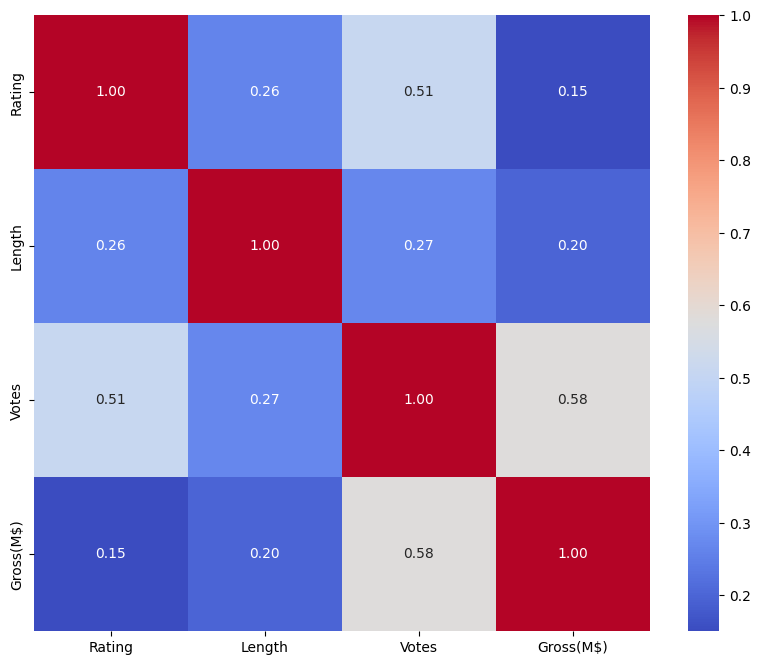

In [96]:
# Creating a smaller DataFrame with only the columns we're interested in
df_small = data_film[['Rating', 'Length', 'Votes', 'Gross(M$)']]

# Then, we calculate the correlation matrix
corr_matrix = df_small.corr()

# Finally, we create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.show()

##### Final conclusion:

- There is a moderate correlation between Rating and the Votes attribute. This indicates that the movies which receive a high number of Votes tend to have high Rating

- The Length and Gross of the movies don't affect most to the Rating of that movies. It means that the movies with a large budget doesn't mean it is a good movie and vice versa

#### 9.5) Question 5: Which director - actor pair often works together?

- Purposes: To identify frequent collaborations between directors and actors in the film industry. This can provide insights into professional relationships and recurring partnerships in filmmaking. Certain director-actor pairs often work together because they share a common vision, have a strong working relationship, or have had success together in the past. Identifying these pairs can give us a better understanding of patterns and trends in the film industry.

- Approaches: For each movie, create pairs of the director and each actor. This could involve splitting the ‘Stars’ field if it contains multiple actors, and pairing each actor with the director. Count the occurrence of each director-actor pair to see which pairs occur most frequently. Visualize the most frequent director-actor pairs using a bar plot. This can make it easier to see which pairs work together most often.

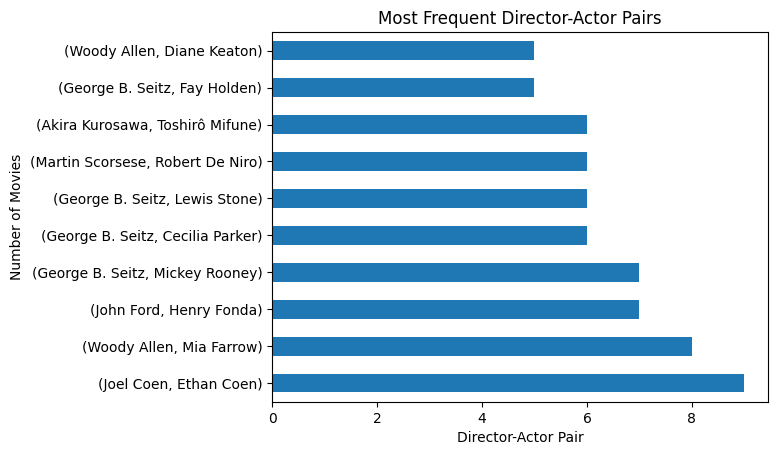

In [97]:
# Create director-actor pairs for each movie, excluding pairs where the director and actor are the same
director_actor_pairs = df_stars.apply(lambda row: (row['Director'], row['Stars_Split']) if row['Director'] != row['Stars_Split'] else None, axis=1)

# Remove None values
director_actor_pairs = director_actor_pairs.dropna()

# Count the occurrence of each director-actor pair
pair_counts = director_actor_pairs.value_counts()

# Visualizing
import matplotlib.pyplot as plt
pair_counts.head(10).plot(kind='barh')
plt.xlabel('Director-Actor Pair')
plt.ylabel('Number of Movies')
plt.title('Most Frequent Director-Actor Pairs')
plt.xticks(rotation=0)
plt.show()

##### Final Conclusion:

1. Joel Coen - Ethan Coen
2. Woody Allen - Mia Farrow
3. John Ford - Henry Fonda
4. George B. Seitz - Mickey Rooney
5. George B. Seitz - Cecilia Parker

These pairs have worked together on numerous projects, suggesting a strong professional relationship and a shared creative vision. Their repeated collaborations could also indicate that these pairs have found a successful formula that resonates with audiences and critics alike.

#### 9.6) Question 6: What are the related movies that people may have interest in?

- **Purpose:**

  When users finish watching a movie in our application, we want to keep them engaged by recommending similar films that captivate their interest and entice them to continue using the app.
- **Approaches:**
  1. To solve this problem we will use `Description` feature
  2. Compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each description.
  3. Compute a similarity score
  4. Return a list of top 10 most similar movies

- Some descriptions:

In [98]:
data_film['Description'].head(5)

0    Don Vito Corleone, head of a mafia family, dec...
1    A cynical expatriate American cafe owner strug...
2    A disillusioned college graduate finds himself...
3    Following the death of publishing tycoon Charl...
4    The jury in a New York City murder trial is fr...
Name: Description, dtype: object

- TF-IDF matrix: Column represents a word in description. Row represents a film

There are **6764 words** in total used in description

In [99]:
TF_IDF = TfidfVectorizer(stop_words='english') # remove 'the', 'a',...

TF_IDF_matrix = TF_IDF.fit_transform(data_film['Description'])

TF_IDF_matrix.shape

(1472, 6764)

- Compute **consine similarity score** by calculating dot product

In [100]:
similarities = linear_kernel(TF_IDF_matrix, TF_IDF_matrix)

- Function used to return related movies

In [101]:
# get index for each movie
indexes = pd.Series(data_film.index, index=data_film['Name']).drop_duplicates()

In [102]:
indexes.head(5)

Name
Bố Già                      0
Chuyện Tình Thế Chiến       1
Sinh Viên Tốt Nghiệp        2
Công Dân Kane               3
12 Người Đàn Ông Giận Dữ    4
dtype: int64

In [103]:
def get_related_movie(name, similarities=similarities):
    # get index of 'name' film
    idx = indexes[name]

    # get the similarites of all the films with `name` film
    similarity_scores = list(enumerate(similarities[idx]))

    # sort similarity score and get top 10 films with highest similarity score with `name` film
    similarity_scores = sorted(similarity_scores, key= lambda x: x[1], reverse=True)[1:11]

    # get the index of top 10 films
    movie_indexes = [score[0] for score in similarity_scores]

    # get the name of top 10 films
    return data_film['Name'].iloc[movie_indexes]

- Suggest related movies

In [104]:
get_related_movie('12 Người Đàn Ông Giận Dữ')

1431    Midnight in the Garden of Good and Evil
534                             Biệt Đội Săn Ma
1344                              Nghị Lực Sống
1242                           Chớp Lấy Thời Cơ
95                               Đi Tìm Vận May
894                       Bunny Lake Is Missing
783          The Taking of Pelham One Two Three
1389                             The Naked City
590                        Synecdoche, New York
555                                    Blow Out
Name: Name, dtype: object

In [105]:
get_related_movie('Phù Thủy Xứ Oz')

496                                    Peter Pan
473                   Cuộc Thi Của Những Chú Chó
611     Harry Potter và Tên Tù Nhân Ngục Azkaban
1496                      Chuyến Du Lịch Châu Âu
970                                The Cocoanuts
1088            Harry Potter và Hội Phượng Hoàng
327              Seven Brides for Seven Brothers
1303                               Marvin's Room
190                                The Big Chill
81                 E.T: Sinh vật Ngoài Hành Tinh
Name: Name, dtype: object

> **Conclusion**: based the importance of words in **description**, we can suggest some related movies to capture users attention and earn some benefits

## Data modeling

### Problem Statement 1

- **The question that our team want to give an answer to is:**  How much grosses can this new film can possibly get?
- **Purpose:**
  When we want to make a film, we sure want to know how much money the film could make for us. The success or failure of a movie depends on many factors: the release date, budget, star-power, marketing,...  But with the data that our team has collected, we will answer the question above by predicting the gross with values of: Ratings. 
  By predicting the gross, the film maker can know wheter it is possible to make the film and the prediction will help them to have a clearer vision on the production plan and distribution stage.
- **How:** To solve this problem we will use Regression model to predict the Gross of the new movie.

### Target Variable

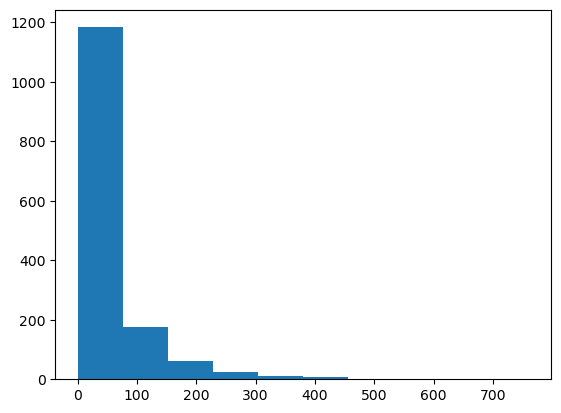

In [106]:
plt.hist(new_data_film['Gross(M$)']);

### Correlation

<Axes: >

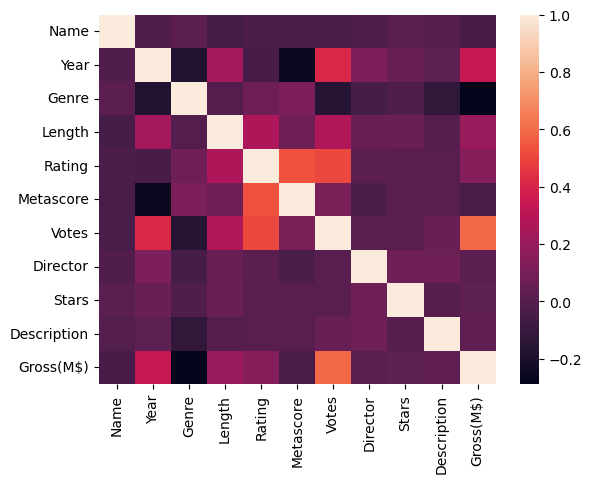

In [107]:
sns.heatmap(new_data_film.corr())

### Data preparation

- We will get the data from `data_film` that has the preprocessed data.

In [36]:
filmdata_df = data_film.copy()
filmdata_df.head()

,Name,Year,Genre,Length,Rating,Metascore,Votes,Director,Stars,Description,Gross(M$)
0,Bố Già,1972.0,"Crime, Drama",175,9.2,100.0,1967180,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...","Don Vito Corleone, head of a mafia family, dec...",134.97
1,Chuyện Tình Thế Chiến,1942.0,"Drama, Romance, War",102,8.5,100.0,595530,Michael Curtiz,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",A cynical expatriate American cafe owner strug...,1.02
2,Sinh Viên Tốt Nghiệp,1967.0,"Comedy, Drama, Romance",106,8.0,83.0,284817,Mike Nichols,"Dustin Hoffman, Anne Bancroft, Katharine Ross,...",A disillusioned college graduate finds himself...,104.95
3,Công Dân Kane,1941.0,"Drama, Mystery",119,8.3,100.0,458887,Orson Welles,"Orson Welles, Joseph Cotten, Dorothy Comingore...",Following the death of publishing tycoon Charl...,1.59
4,12 Người Đàn Ông Giận Dữ,1957.0,"Crime, Drama",96,9.0,97.0,841356,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",The jury in a New York City murder trial is fr...,4.36


### Data Preprocessing

- We will remove all the row in the DataFrame that has Gross equal to 0.

In [37]:
feature_cols = ['Rating', 'Gross(M$)']

modeling_data = filmdata_df[feature_cols].copy()
modeling_data['Gross(M$)'] = modeling_data['Gross(M$)'].fillna(0)
modeling_data.Rating = modeling_data.Rating.fillna(0)
modeling_data = modeling_data[~(modeling_data['Gross(M$)'] == 0)]

- Split the dataset into X_train, y_train, X_test, y_test and create Train dataset and Test dataset.

In [38]:
X, y = modeling_data.drop(['Gross(M$)'], axis= 1), modeling_data['Gross(M$)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [39]:
train_data = X_train.join(y_train)
train_data

,Rating,Gross(M$)
1060,7.7,16.42
336,8.1,3.27
758,7.4,47.95
513,6.7,31.90
1303,6.7,12.78
...,...,...
883,6.7,40.26
1048,7.0,70.17
662,7.1,38.75
1094,7.3,79.10


In [40]:
test_data = X_test.join(y_test)
test_data

,Rating,Gross(M$)
236,8.0,106.95
1398,5.4,2.74
629,7.5,55.69
492,7.9,20.61
1317,6.7,2.74
...,...,...
1015,6.6,36.40
390,8.3,75.60
136,7.6,132.09
314,7.9,0.05


### Creating Model

- For the Regression model, our team choose Linear Regression and Ridge Regression.

In [41]:
class LinearRegression:
    '''
    lr: the learning rate
    n_iters: the max iterations for the fit function to run
    '''
    def __init__(self, lr, n_iters):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_pred = self.predict(X)

            # Update the Weights and Bias
            dW = - ( 2 * X.T.dot( y - y_pred ) ) / n_samples
            db = - 2 * np.sum( y - y_pred ) / n_samples
            self.weights = self.weights - self.lr *dW
            self.bias = self.bias - self.lr * db

    def predict(self, X):
        y_pred = np.dot(X, self.weights) + self.bias
        return y_pred
    
class RidgeRegression:
    '''
    lr: the learning rate
    n_iters: the max iterations for the fit function to run
    lamda: the values used to update the weights 
    '''
    def __init__(self, lr, n_iters, lamda):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.lamda = lamda 
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_pred = self.predict(X)
            
            # Update the Weights and Bias
            dW = ( - ( 2 * ( X.T ).dot( y - y_pred ) ) +  ( 2 * self.lamda * self.weights ) ) / n_samples   
            db = - 2 * np.sum( y - y_pred ) / n_samples
            self.weights = self.weights - self.lr *dW
            self.bias = self.bias - self.lr * db

    def predict(self, X):
        y_pred = np.dot(X, self.weights) + self.bias
        return y_pred

### Chosing Metrics

- As for the Metrics, we will use the Mean Absolute Error and mse to have more insight of the error of each model.

In [42]:
def mae(y_test, predictions):
    return np.mean(abs(y_test-predictions))


### Trainning and Validating Model

- For the training and validating model, we will use K-Fold cross validation with 10 folds to train and validate the model. 

In [43]:
# Initilizing Variables
X_train, y_train = train_data.drop(['Gross(M$)'], axis= 1), train_data['Gross(M$)']
X_test, y_test = test_data.drop(['Gross(M$)'], axis= 1), test_data['Gross(M$)']

learning_rate = 0.0001
n_iters = 1000
lamda = 1000

model_1 = LinearRegression(lr= learning_rate, n_iters =n_iters)
model_2 = RidgeRegression(lr= learning_rate, n_iters =n_iters, lamda = lamda)

In [44]:
def k_fold_cross_validation(n_folds, X, y, model):
    kf = KFold(n_splits= n_folds, shuffle= True)
    fold = kf.split(X, y)
    mae_score = []
    history = {}
    count = 0
    
    for train_idx, val_idx in fold:
        X_tr = X.iloc[train_idx]
        y_tr = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        new_mae = mae(y_val, y_pred)
        mae_score.append(new_mae)
        print("===== Fold",count,"=====")
        print("MSE=", new_mae)
        history[count] = new_mae
        count+= 1
        

    avg_mse = np.mean(mae_score)
    return avg_mse, history

In [45]:
number_of_fold = 10
print("======= Linear Regression =======")
k_fold_linear, linear_history = k_fold_cross_validation(number_of_fold, X_train, y_train, model_1)
print("===========================")
print("Avg. MAE= ", k_fold_linear)
print()

print("======= Ridge Regression =======")
k_fold_ridge, ridge_history= k_fold_cross_validation(number_of_fold, X_train, y_train, model_2)
print("===========================")
print("Avg. MAE= ", k_fold_ridge)
print()

======= Linear Regression =======
===== Fold 0 =====
MSE= 47.037982013105164
===== Fold 1 =====
MSE= 56.530201105634255
===== Fold 2 =====
MSE= 48.94975518024323
===== Fold 3 =====
MSE= 60.50762619727474
===== Fold 4 =====
MSE= 60.220529567632155
===== Fold 5 =====
MSE= 51.50120686379783
===== Fold 6 =====
MSE= 50.73867452630678
===== Fold 7 =====
MSE= 56.33139294911497
===== Fold 8 =====
MSE= 60.68000736849156
===== Fold 9 =====
MSE= 54.052546559849546
Avg. MAE=  54.65499223314502

======= Ridge Regression =======
===== Fold 0 =====
MSE= 54.65636670607676
===== Fold 1 =====
MSE= 55.45219182009243
===== Fold 2 =====
MSE= 60.37805320317433
===== Fold 3 =====
MSE= 50.96181759533805
===== Fold 4 =====
MSE= 50.57092045003777
===== Fold 5 =====
MSE= 58.10048420650632
===== Fold 6 =====
MSE= 55.25476275602907
===== Fold 7 =====
MSE= 52.46099386877934
===== Fold 8 =====
MSE= 52.55388147073565
===== Fold 9 =====
MSE= 51.34522126581646
Avg. MAE=  54.17346933425862



### Re-Train Model

- Re-train the model on the whole Train dataset

In [46]:
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

### Testing Model

- Use the model to predict the Test dataset


In [47]:
y_pred = model_1.predict(X_test)
test_mae = mae(y_test, y_pred)
print("Linear Regression Testing MAE= ", test_mae)

y_pred = model_2.predict(X_test)
test_mae = mae(y_test, y_pred)
print("Ridge Regression Testing MAE= ", test_mae)

Linear Regression Testing MAE=  55.02001906066242
Ridge Regression Testing MAE=  54.615704696412045


### Evaluation

- Both Linear Regression model and Ridge Regression model have nearly the same error. 
- The Mean Absolute Error of both models are quite high, about 54. But since we are working on the number million, 54 million is a acceptable value.
- Clearly both of these models are not the most suitable model to predict the gross. 

### Visualizing

-  Running Process

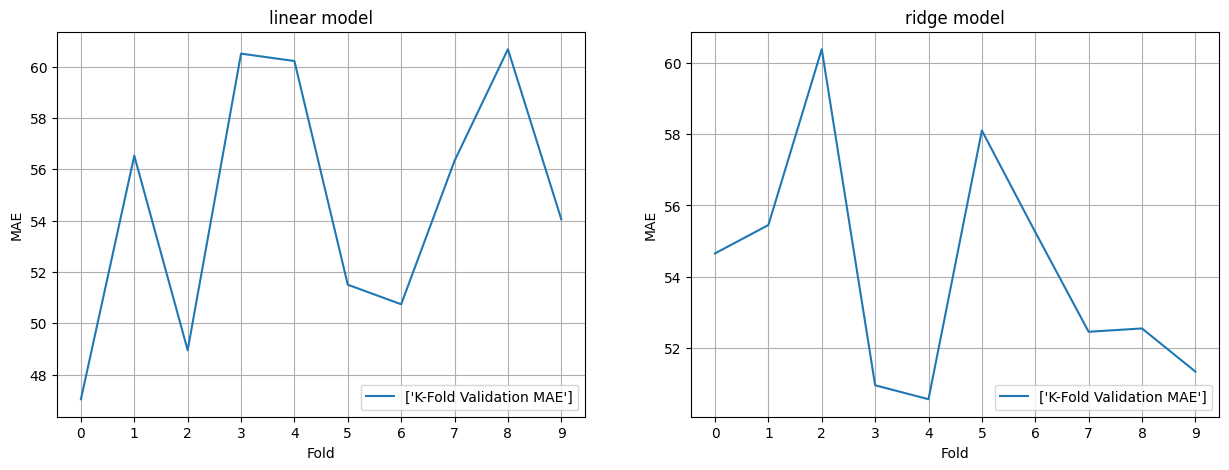

In [48]:
plt.figure(figsize=(15, 5))

history = []
for i in range(len(linear_history)):
  history.append(linear_history[i])

plt.subplot(1, 2, 1)
plt.plot(history, label=["K-Fold Validation MAE"])
plt.title("linear model")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.grid()
plt.xticks(np.arange(0, 10, step=1))
plt.legend(loc="lower right")

history = []
for i in range(len(ridge_history)):
  history.append(ridge_history[i])

plt.subplot(1, 2, 2)
plt.plot(history, label=["K-Fold Validation MAE"])
plt.title("ridge model")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.grid()
plt.xticks(np.arange(0, 10, step=1))
plt.legend(loc="lower right")

- Result

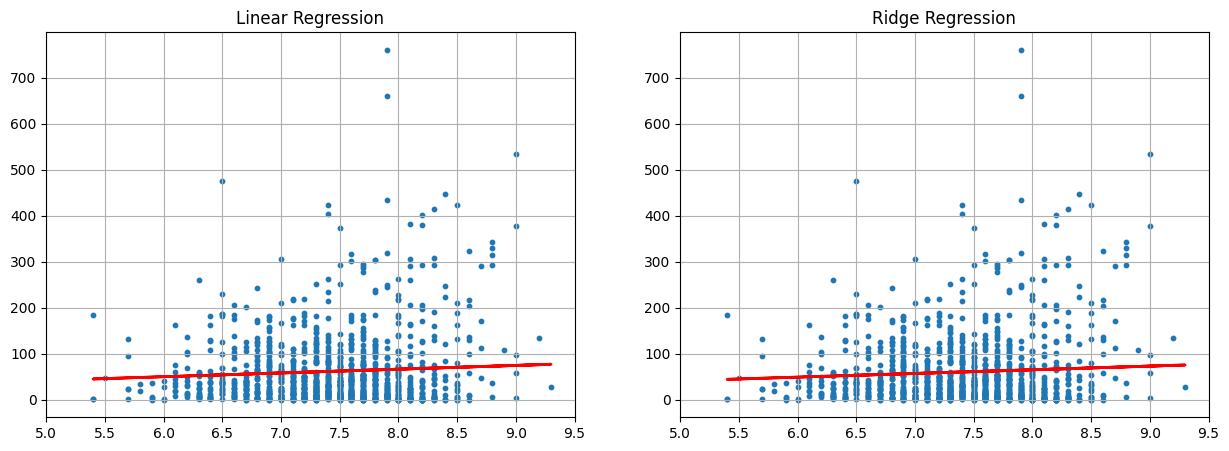

In [49]:
plt.figure(figsize=(15, 5))

y_pred_line_1 = model_1.predict(X)
y_pred_line_2 = model_2.predict(X)

plt.subplot(1, 2, 1)
plt.scatter(X, y, s=10)
plt.plot(X, y_pred_line_1, color='red', linewidth=2)
plt.title('Linear Regression')
plt.xticks(np.arange(5, 10, 0.5))
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(X, y, s=10)
plt.plot(X, y_pred_line_2, color='red', linewidth=2)
plt.title('Ridge Regression')
plt.xticks(np.arange(5, 10, 0.5))
plt.grid()
plt.show()

> After fitting with 1 `Rating` feature, we found that the result is good. However, Our team want to improve the result more. Therefore we will choose a model to tuning its hyperparameter

### Best model for tuning?

 - First, we will remove `Description` and `Name` feature

In [122]:
new_data_film = new_data_film.drop(columns=['Description', 'Name'], axis=1)

- Prepare data

In [123]:
X = new_data_film.drop('Gross(M$)', axis=1)
y = new_data_film['Gross(M$)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
X_train.head()

,Year,Genre,Length,Rating,Metascore,Votes,Director,Stars
1016,1968.0,4,104,6.8,65.0,3988,614,661
255,2004.0,85,170,7.5,77.0,378364,226,945
1092,1995.0,148,122,7.5,80.0,100108,591,1310
655,1990.0,85,121,7.8,74.0,154294,449,1170
1479,1988.0,202,121,6.7,53.0,17041,346,1432


In [125]:
y_train.head()

1016     32.725
255     102.610
1092     39.390
655      52.100
1479     32.630
Name: Gross(M$), dtype: float64

- Create model

In [126]:
models = {
    'SVR':SVR(),
    'XGBRegressor': XGBRegressor(),
    'Ridge': linear_model.Ridge(),
    'ElasticNet': ElasticNet(),
    'SGDRegressor': SGDRegressor(),
    'BayesianRidge': BayesianRidge(),
    'LinearRegression': linear_model.LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor()
}

- Fit model

In [138]:
model_results = []
model_names = []

for name,model in models.items():
    a = model.fit(X_train,y_train)
    predicted = a.predict(X_test)
    score = mean_absolute_error(y_test, predicted)
    model_results.append(score)
    model_names.append(name)
    
    #creating dataframe
    df_results = pd.DataFrame([model_names,model_results])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0:'Model',1:'MAE'}).sort_values(by='MAE',ascending=False)
    
print(df_results)

                   Model                      MAE
4           SGDRegressor  137057541002941579264.0
5          BayesianRidge                34.493607
3             ElasticNet                34.262854
6       LinearRegression                34.034952
2                  Ridge                 34.03258
0                    SVR                33.115959
1           XGBRegressor                28.171795
7  RandomForestRegressor                28.104454


> By far, `RandomForestRegressor` give us the best result so we will use this model for tuning 

#### Hyperparameter Tuning

In [128]:
# %%time

# import optuna

# def objective(trial):
 
#     param = {
#         'n_estimators': trial.suggest_categorical('n_estimators', [100, 500, 1000, 1250, 1500, 2000]),
#         'max_depth': trial.suggest_categorical('max_depth', [10, 25, 50, 100, 200]),
#         'min_samples_split': trial.suggest_categorical('min_samples_split', [10, 25, 50, 100, 200]),
#         'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [10, 25, 50, 100, 200]),
#         'max_features': trial.suggest_categorical('max_features', [0.5, 1, 'sqrt'])
#     }
    
#     model = RandomForestRegressor(**param)  
    
#     model.fit(X_train, y_train)
#     preds_valid = model.predict(X_test)
#     rmse = mean_squared_error(y_test, preds_valid, squared=False)
#     return rmse

    
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=5000)

# study.best_params

- Best parameters for `RandomForestRegressor`

In [152]:
best_params = {'n_estimators': 100,
 'max_depth': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 0.5}

In [153]:
model = RandomForestRegressor(**best_params)

In [154]:
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(f'Root Mean Square Error test = {mean_squared_error(y_test, predicted,squared=False)}')

Root Mean Square Error test = 46.21128609686412


In [155]:
y_preds = model.predict(X_test)
print("After Tuning, the MAE is", mean_absolute_error(y_test, y_preds))

After Tuning, the MAE is 28.690047419621003


In [ ]:
plt.scatter(y_preds, y_test)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('The correctness of model prediction')
plt.show()

> **Conclusion**: With training on multiple models and hyperparameter tuning, the model does not improve. Therefore, the default parameters by far give us the best result. Our groups think that due to lacking observations, the model does not have enough data to learn. The tuning process takes place around 30 minutes to find the best combination of hyperparameter for RandomForestRegressor.

- Save predictions and true values to .csv file

In [156]:
result = {
    'predict_value': y_preds,
    'true_value': y_test,
}


pd.DataFrame(result).to_csv('result.csv', index=False)

## References

1. https://www.kaggle.com/code/heyrobin/house-price-prediction-beginner-s-notebook/notebook
2. https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system